## Análisis de datos - Clase 5

### Técnicas avanzadas para el tratamiento de datos faltantes

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

### Identificamos datos faltantes

Cargamos el dataset

In [95]:
# Cargamos el dataset de Titanic de Seaborn
titanic = sns.load_dataset("titanic")
# Creo una copia reducida del dataset original para simplificar el ejemplo (dejo un solo feature con faltantes)
titanic = titanic[['age', 'pclass', 'sex', 'embarked', 'survived']].dropna(subset=['embarked'])


Hacemos el split

In [96]:
# Definimos los features
X = titanic.loc[:, ['age', 'pclass', 'sex', 'embarked']]

# Definimos la variable target
y = titanic.loc[:, 'survived']

# Hacemos el split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify=y) 

# Verificamos dimensiones
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(711, 4) (711,) (178, 4) (178,)


In [97]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 621 to 507
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       571 non-null    float64
 1   pclass    711 non-null    int64  
 2   sex       711 non-null    object 
 3   embarked  711 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 27.8+ KB


In [98]:
X_train

,age,pclass,sex,embarked
621,42.0,1,male,S
481,NaN,2,male,S
527,NaN,1,male,S
435,14.0,1,female,S
797,31.0,3,female,S
...,...,...,...,...
359,NaN,3,female,Q
643,NaN,3,male,S
736,48.0,3,female,S
462,47.0,1,male,S


In [99]:
X_train.isna().sum()[X_train.isna().sum() > 0] # columnas con datos faltantes

age    140
dtype: int64

In [100]:
X_test.isna().sum()[X_test.isna().sum() > 0] # columnas con datos faltantes

age    37
dtype: int64

### Tratamiento de datos faltantes

#### Imputación - Métodos multivariados

Cuando tengo datos MAR con patrones claros

* KNN (*K-Nearest Neighbors*)

Cuando tengo datos MAR con patrones complejos
* MICE (*Multiple Imputation by Chained Equations*)

#### a) Imputación con KNN

In [101]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

In [102]:
ohe = OneHotEncoder(sparse_output=False) 

# Ajustar y transformar
X_cat_train_encoded_array = ohe.fit_transform(X_train[['sex', 'embarked']]) # Esto devuelve un array de numpy

# Extraer nombres de columnas nuevas creadas por el encoder
ohe_col_names = ohe.get_feature_names_out(['sex', 'embarked'])

# Convertir a DataFrame 
X_cat_train_encoded = pd.DataFrame(X_cat_train_encoded_array, columns=ohe_col_names, index=X_train.index) 

# Unir con el df original
X_train_encoded = pd.concat([X_train, X_cat_train_encoded], axis=1)

# Borrar columnas originales
X_train_encoded = X_train_encoded.drop(columns=['sex', 'embarked'])

# Df final codificado:
X_train_encoded.head()



,age,pclass,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
621,42.0,1,0.0,1.0,0.0,0.0,1.0
481,NaN,2,0.0,1.0,0.0,0.0,1.0
527,NaN,1,0.0,1.0,0.0,0.0,1.0
435,14.0,1,1.0,0.0,0.0,0.0,1.0
797,31.0,3,1.0,0.0,0.0,0.0,1.0


In [103]:
# Codifico test con el algoritmo ajustado en train
X_cat_test_encoded_array = ohe.transform(X_test[['sex', 'embarked']])

# Convertir a DataFrame
X_cat_test_encoded = pd.DataFrame(X_cat_test_encoded_array, columns=ohe_col_names, index=X_test.index) 

# Unir con el df original
X_test_encoded = pd.concat([X_test, X_cat_test_encoded], axis=1)

# Borrar columnas originales
X_test_encoded = X_test_encoded.drop(columns=['sex', 'embarked'])

# Df final codificado:
X_test_encoded.head()

,age,pclass,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
160,44.0,3,0.0,1.0,0.0,0.0,1.0
126,NaN,3,0.0,1.0,0.0,1.0,0.0
428,NaN,3,0.0,1.0,0.0,1.0,0.0
422,29.0,3,0.0,1.0,0.0,0.0,1.0
565,24.0,3,0.0,1.0,0.0,0.0,1.0


In [104]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 621 to 507
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         571 non-null    float64
 1   pclass      711 non-null    int64  
 2   sex_female  711 non-null    float64
 3   sex_male    711 non-null    float64
 4   embarked_C  711 non-null    float64
 5   embarked_Q  711 non-null    float64
 6   embarked_S  711 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 44.4 KB


In [105]:
X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 160 to 637
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         141 non-null    float64
 1   pclass      178 non-null    int64  
 2   sex_female  178 non-null    float64
 3   sex_male    178 non-null    float64
 4   embarked_C  178 non-null    float64
 5   embarked_Q  178 non-null    float64
 6   embarked_S  178 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 11.1 KB


Prerequisito para KNNImputer: escalamiento

In [106]:
# Prerequisito para KNNImputer: escalamiento
scaler = MinMaxScaler()
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)

In [110]:
# Definimos el modelo
knn_imputer = KNNImputer(n_neighbors=5)

# Aplicamos la imputación
X_train_encoded_scaled_imputed = pd.DataFrame(
    knn_imputer.fit_transform(X_train_encoded_scaled),
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)

X_train_encoded_scaled_imputed

,age,pclass,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
621,0.520505,0.0,0.0,1.0,0.0,0.0,1.0
481,0.424606,0.5,0.0,1.0,0.0,0.0,1.0
527,0.488757,0.0,0.0,1.0,0.0,0.0,1.0
435,0.167192,0.0,1.0,0.0,0.0,0.0,1.0
797,0.381703,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
359,0.249211,1.0,1.0,0.0,0.0,1.0,0.0
643,0.232808,1.0,0.0,1.0,0.0,0.0,1.0
736,0.596215,1.0,1.0,0.0,0.0,0.0,1.0
462,0.583596,0.0,0.0,1.0,0.0,0.0,1.0


Verificamos que no hay más nulos

In [111]:
X_train_encoded_scaled_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 621 to 507
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         711 non-null    float64
 1   pclass      711 non-null    float64
 2   sex_female  711 non-null    float64
 3   sex_male    711 non-null    float64
 4   embarked_C  711 non-null    float64
 5   embarked_Q  711 non-null    float64
 6   embarked_S  711 non-null    float64
dtypes: float64(7)
memory usage: 44.4 KB


Desescalo los datos imputados de train para poder graficar y comparar la variable $\texttt{age}$ antes y después de imputar:

In [114]:
X_train_imputed_descaled = pd.DataFrame(
    scaler.inverse_transform(X_train_encoded_scaled_imputed), # desescalar
    columns=X_train_encoded.columns,
    index=X_train_encoded.index
)

X_train_imputed_descaled

,age,pclass,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
621,42.000,1.0,0.0,1.0,0.0,0.0,1.0
481,34.400,2.0,0.0,1.0,0.0,0.0,1.0
527,39.484,1.0,0.0,1.0,0.0,0.0,1.0
435,14.000,1.0,1.0,0.0,0.0,0.0,1.0
797,31.000,3.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
359,20.500,3.0,1.0,0.0,0.0,1.0,0.0
643,19.200,3.0,0.0,1.0,0.0,0.0,1.0
736,48.000,3.0,1.0,0.0,0.0,0.0,1.0
462,47.000,1.0,0.0,1.0,0.0,0.0,1.0


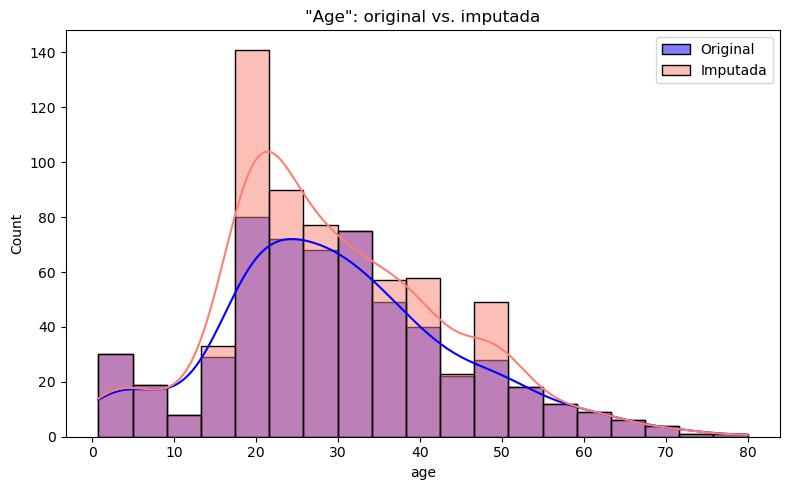

In [140]:
# Visualizar datos originales vs imputados (por ejemplo con el primer dataset imputado)
plt.figure(figsize=(8, 5))

# Age distribution
sns.histplot(X_train['age'], label='Original', kde=True, color='blue')
sns.histplot(X_train_imputed_descaled['age'], label='Imputada', kde=True, color='salmon')
plt.title('"Age": original vs. imputada')
plt.legend()

plt.tight_layout()
plt.show()
